<a href="https://colab.research.google.com/github/asafdari-boop/ComputationalPhyiscsLibrary/blob/main/FFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Discrete Fourier Transform
A periodic function $f(x)$ defined on a finite interval $0 \le x < L$ can be written as a Fourier series

$
f(x) = \sum_{k=0}^{\infty} \alpha_k \cos(\frac{2\pi kx}{L}) + \sum_{k=1}^{\infty} \beta_k \sin(\frac{2\pi kx}{L}) = \sum_{k=-\infty}^{\infty} \gamma_k \exp(i\frac{2\pi kx}{L})
$
where we have
$
\gamma_k = \frac{1}{N} \sum_{n=0}^{N-1} f(x_n) \exp(-i \frac{2\pi k x_n}{L})
$

Often $f(x)$ is not known in analytic form. Assume we have data taken with $N$ slices of width $h=L/N$ each, so with the trapezoidal rule we have

$
\gamma_k = \frac{1}{L}\frac{L}{N} [\frac{1}{2} f(0)+\frac{1}{2} f(L)+\sum_{n=1}^{N-1} f(x_n) \exp(-i\frac{2\pi kx_n}{L})]
$

with $x_n=\frac{n}{N}L$. Since $f(x)$ is by hyopthesis periodic we have $f(L)=f(0)$, and thus we have

$
\gamma_k = \frac{1}{N} \sum_{n=0}^{N-1} f(x_n) \exp(-i\frac{2\pi kn}{N})= \frac{1}{N} \sum_{n=0}^{N-1} y_n \exp(-i\frac{2\pi kn}{N})
$

where $y_n$ are the values of the $N$ samples. 

People often define $c_k$ to be the discrete Fourier transform (DFT) of the samples $y_n$:

$
c_k = \sum_{n=0}^{N-1} y_n \exp(-i\frac{2\pi kn}{N})
$

The inverse DFT is found to be:

$
y_n = \frac{1}{N} \sum_{k=0}^{N-1} c_k \exp(i\frac{2\pi kn}{N})
$

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from cmath import exp, pi

def DFT(y):
  N = len(y)
  c = np.zeros(N//2+1, complex)
  for k in range(N//2+1):
    for n in range(N):
      c[k] += y[n]*exp(-2j*pi*k*n/N)
  return c

In [ ]:
from google.colab import drive
from google.colab import files
import timeit

def signal_pitch():
  #mount your google drive to google colab
  drive.mount('/content/drive/')

  #since the code will be run on a virtual machine, we need to copy the python file to that machine in order to run it
  !cp /content/drive/My\ Drive/Colab\ Notebooks/PHYS411/ExtraMaterial/pitch.txt .

  # loading the data
  y = np.loadtxt("./pitch.txt", float)
  print(len(y), "data points used")
  return y

Mounted at /content/drive/
1024 data points used
Total time takes for the slow DFT:  1.7084839669999923


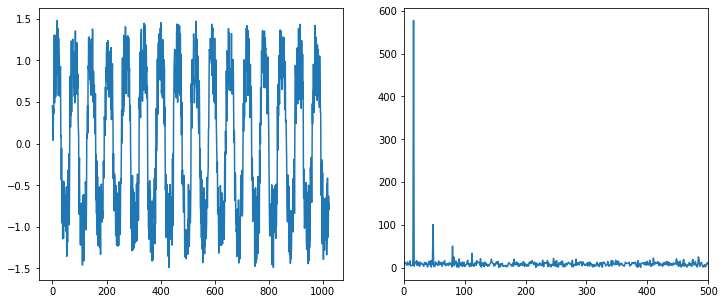

In [ ]:
# obtain the pitch signal
y = signal_pitch()

# DFT
start_time = timeit.default_timer()
c = DFT(y)
end_time = timeit.default_timer()
print("Total time takes for the slow DFT: ", end_time-start_time)

plt.figure(figsize = (12, 5))
plt.subplot(121)
plt.plot(y)
plt.subplot(122)
plt.plot(abs(c))
plt.xlim(0, 500)
plt.show()

DFT is too slow, audio sample rate is around 44 kHz

### Fast Fourier Transform (FFT)

Need to find a fast way to evaluate

$
c_k = \sum_{n=0}^{N-1} y_n \exp(-i\frac{2\pi kn}{N})
$

and 

$
y_n = \frac{1}{N} \sum_{k=0}^{N-1} c_k \exp(i\frac{2\pi kn}{N})
$

**FFT: "the most important numerical algorithm of our lifetime" (Gilbert Strang), included in Top 10 Algorithms of 20th Century by the IEEE magazine Computing in Science & Engineering**

Gauss first had the FFT idea in his unpublished work back in 1805, Cooley and Tukey are generally credited for the invention of the modern generic FFT algorithm. Tukey came up with the idea during a meeting of President Kennedy's Science Advisory Committee where a discussion topic involved detecting nuclear tests by the Soviet Union by setting up sensors to surround the country from outside. In discussion with Tukey, Richard Garwin recognized the general applicability of the algorithm not just to national security problems, but also to a wide range of problems. Garwin gave Tukey's idea to Cooley for implementation. -- wikipedia  

### Multiplication of two polynomial functions

1. **Polynomial representation
$P(x)=p_0 + p_1x + p_2 x^2 + ... + p_n x^n$**
- Coefficient representation: $[p_0, p_1, ..., p_n]$
- Value representation: ${(x_0, P(x_0), (x_1, P(x_1), ..., (x_n, P(x_n),}$ since $(n+1)$ points uniquely define a degree $n$ polynomial
- For example, $A(x)=x^2+2x+1$ can be presented by three points (0, 1), (1, 4), and (2, 9), and $B(x)=x^2-2x+1$ can be presented by three points (0, 1), (1, 0) and (2, 1). While for $C(x)=A(x) \cdot B(x)=x^4-2x^2+1$, it is a degree-4 polynomial, and thus we need to have five points to present this function
- We can choose five points for $A(x)$ and $B(x)$ also, so we have (-2, 1), (-1, 0), (0, 1), (1, 4), and (2, 9) for $A(x)$, and (-2, 9), (-1, 4), (0, 1), (1, 0) and (2, 1) for $B(x)$. Since $x$ values are the same for all five points, we can just multiply their $y$ values individually, and we have (-2, 9), (-1, 0), (0, 1), (1, 0) and (2, 9). You will find that these five points will define a new polynomial function $x^4-2x^2+1$, which is exactly $A(x) \cdot B(x)$
- The steps are: (Coeff --> Value) -- Multiply -- (Value --> Coeff).

2. **Coeff--> Value (Evaluation, FFT)**
- if we directly evalute the values for $n$ points for a degree $n$ polynomial, **the number of operations is $O(n^2)$**. 
- For even functions such as $P(x)=x^2$, if we evaluate the value at x=1, we immediately know the value at x=-1 since $P(-x)=P(x)$. 
- For odd functions such as $P(x)=x^3$, if we evaluate the value at x=1, we immediately know the value at x=-1 since $P(-x)=-P(x)$. 
- For functions such as $P(x)=3x^5+2x^4+x^3+7x^2+5x+1$, can separate it to even and odd functions as $P(x) = (2x^4+7x^2+1)+(3x^5+x^3+5x)=(2x^4+7x^2+1)+x(3x^4+x^2+5)=P_e(x^2)+xP_o(x^2)$. With this formula, we have $P(x_i)=P_e(x_i^2)+x_i P_o(x_i^2)$ and $P(-x_i)=P_e(x_i^2)-x_i P_o(x_i^2)$. Once we know how to calculate $P(x_i)$, we can easily find $P(-x_i)$.
- For any polynomial function $P(x)=p_0+p_1x+...+p_{n-1}x^{n-1}$, we need to evaluate the function values at $n$ points $\pm x_1$, $\pm x_2$, ..., $\pm x_{n/2}$. We can follow the above approach, and have $P(x_i)=P_e(x_i^2)+x_i P_o(x_i^2)$ and $P(-x_i)=P_e(x_i^2)-x_i P_o(x_i^2)$. $P_e(x^2)$ and $P_o(x^2)$ both have degree $n/2-1$. It becomes another polynomial evaluation problems for $P_e(x^2)$ and $P_o(x^2)$ at $x_1^2$, $x_2^2$, ..., $x^2_{n/2}$ with only $n/2$ points. 
- Use the recursive method, and **the number of operations is $O(n \log_2 n)$**. Huge improvements for large $n$s. If $n=10^9$, $n^2$ operations could take about 30 years, while $n\log_2 n$ operations will take about 30 seconds.
3. **Complex plane and $n-$th root of unity**
- There are serious issues in the recursive process. The issue is at the first level, points $[\pm x_1, \pm x_2, ..., \pm x_{n/2}]$ are positive-negative paired, while at the next level, points $[x_1^2, x_2^2, ..., x^2_{n/2}]$ are not positive-negative paired. Is it possible to get points $[x_1^2, x_2^2, ..., x^2_{n/2}]$ are not positive-negative paired?
- Need to have some of the original points to be complex numbers!
- For example $P(x)=x^3+x^2-x+1$, we have
the first level $x_1$, $-x_1$, $x_2$, $-x_2$, and then the second level we have $x_1^2$ and $x_2^2$, and at the third level, we have $x_1^4$. To make the recursion work, we need to have $x_2^2=-x_1^2$ at the second level. We have freedom to choose $x_1$ and $x_2$, and if we set $x_1=1$, we have 1, 1, $x_2$ and $-x_2$ at the first level, and 1, $x_2^2$ at the second level, and 1 at the third level. To make the second level also positive-negative paired, we need to have $x_2^2=-1$. Thus we need to have 1, -1,  $i$ and $-i$ at he first level. 
- For $P(x)=p_0+p_1x+...+p_dx^d$, we need to have $n\ge (d+1)$ points, often choose it to be a power of 2, so we have $n=2^k$. 
- $n-$th root of unity: Equally spaced points on the unit circle with an separation angle of $2\pi/n$. If we define $\omega=e^{i2\pi/n}$, we have $\omega^0$, $\omega^1$, ..., $\omega^{n-1}$ for these $n$ roots. We have $\omega^{j+n/2}=-\omega^j$, so these two points are positve-negative paired. Also after we square all roots, they become the $n/2-$th roots of unity. Thus we can calculate $y[j]$ and $y[j+n/2]$ at the same time. 

4. **Value --> Coeff (Interpretation, Inverse FFT)**
- For Evaluation/FFT we want to do

$
\begin{pmatrix}
P(x_0) \\
P(x_1) \\
P(x_2) \\
\cdots \\
P(x_{n-1}) \\
\end{pmatrix}=\begin{pmatrix}
1 & x_0 & x_0^2 & ... & x_0^{n-1} \\
1 & x_1 & x_1^2 & ... & x_1^{n-1} \\
1 & x_2 & x_2^2 & ... & x_2^{n-1} \\
\cdots \\
1 & x_{n-1} & x_{n-1}^2 & ... & x_{n-1}^{n-1} \\
\end{pmatrix} \begin{pmatrix}
p_0 \\
p_1 \\
p_2 \\
\cdots \\
p_{n-1} \\
\end{pmatrix}
$

since we evaulate these points at $n-$th root of unity, we can let $x_k=\omega^k$ and thus we have

$
\begin{pmatrix}
P(\omega^0) \\
P(\omega^1) \\
P(\omega^2) \\
\cdots \\
P(\omega^{n-1}) \\
\end{pmatrix}=\begin{pmatrix}
1 & 1 & 1 & ... & 1 \\
1 & \omega & \omega^2 & ... & \omega^{n-1} \\
1 & \omega^2 & \omega^4 & ... & \omega^{2(n-1)} \\
\cdots \\
1 & \omega^{n-1} & \omega^{2(n-1)} & ... & \omega^{(n-1)(n-1)} \\
\end{pmatrix} \begin{pmatrix}
p_0 \\
p_1 \\
p_2 \\
\cdots \\
p_{n-1} \\
\end{pmatrix}
$

- For interpolation/IFFT, we have 

$
\begin{pmatrix}
p_0 \\
p_1 \\
p_2 \\
\cdots \\
p_{n-1} \\
\end{pmatrix} = \frac{1}{n}  \begin{pmatrix}
1 & 1 & 1 & ... & 1 \\
1 & \omega^{-1} & \omega^{-2} & ... & \omega^{-(n-1)} \\
1 & \omega^{-2} & \omega^{-4} & ... & \omega^{-2(n-1)} \\
\cdots \\
1 & \omega^{-(n-1)} & \omega^{-2(n-1)} & ... & \omega^{-(n-1)(n-1)} \\
\end{pmatrix} \begin{pmatrix}
P(\omega^0) \\
P(\omega^1) \\
P(\omega^2) \\
\cdots \\
P(\omega^{n-1}) \\
\end{pmatrix}
$


### FFT

In [ ]:
# the input has to be a power of 2
from cmath import exp, pi

def FFT(p):
  n = len(p)
  if n == 1:
    return p
  w = exp(2*pi*1j/n)
  
  y_even = FFT(p[0::2])
  y_odd =  FFT(p[1::2])
  
  y = [0.] * n
  for i in range(n//2):
    factor = w**i
    y[i]      = y_even[i] + y_odd[i] * factor
    y[i+n//2] = y_even[i] - y_odd[i] * factor
  return np.array(y)

##############################################################################
### Another more succinct way to code the FFT algorithm (7 lines in total)
##############################################################################
#def FFT(p):
#  n = len(p)
#  if n == 1:
#    return p
  
#  y_even = FFT(p[0::2])   
#  y_odd = FFT(p[1::2])  

#  factors = np.exp(-2j*np.pi*np.arange(n)/ n)
#  y = np.concatenate([y_even + factors[:int(n/2)]*y_odd, y_even + factors[int(n/2):]*y_odd])
#  return y

### Inverse FFT

In [ ]:
# the input has to be a power of 2
from cmath import exp, pi

def _IFFT(p):
  n = len(p)   # this value changes everytime we do one recursion
  if n == 1:
    return p
  w = exp(-2*pi*1j/n)

  y_even = _IFFT(p[0::2])
  y_odd =  _IFFT(p[1::2])
  y = [0.] * n
  for i in range(n//2):
    factor = w**i
    y[i]      = (y_even[i] + y_odd[i] * factor)
    y[i+n//2] = (y_even[i] - y_odd[i] * factor)
  return np.array(y)

# apply the factor 1/n for each entry
def IFFT(p):
  n = len(p)
  return [x/n for x in _IFFT(p)]

### FFT/IFFT can be significantly faster than the DFT algorithm

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
1024 data points used
Total time takes for FFT:  0.02021333200001152


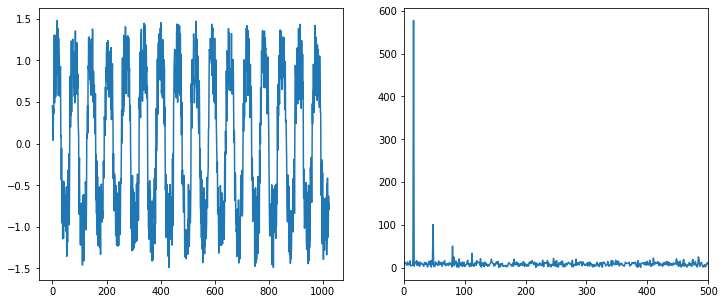

Raw feqs =  [ 6.6603016  13.2773058  11.44706942 ...  9.57213815 11.44706942
 13.2773058 ]
Feqs after the truncation =  [0. 0. 0. ... 0. 0. 0.]


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


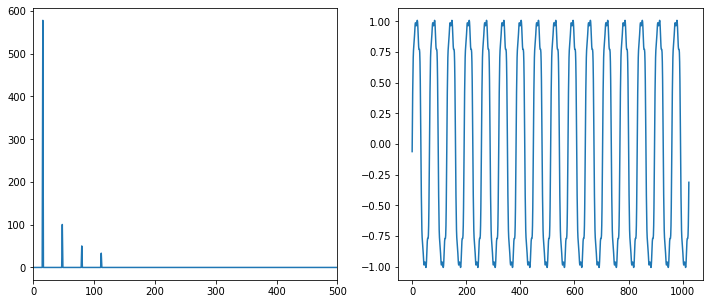

In [ ]:
# obtain the pitch signal
y = signal_pitch()

# FFT
start_time = timeit.default_timer()
d = FFT(y)
end_time = timeit.default_timer()
print("Total time takes for FFT: ", end_time-start_time)

plt.figure(figsize = (12, 5))
plt.subplot(121)
plt.plot(y)
plt.subplot(122)
plt.plot(abs(d))
plt.xlim(0, 500)
plt.show()

print("Raw feqs = ", abs(d))

### only keep these frequencies with absolute values above 30
### reduce the size of memory space needed 
d[abs(d) < 30.] = 0.0
print("Feqs after the truncation = ", abs(d))

# Do an inverse Fourier transform on the signal
isig = IFFT(d)
plt.figure(figsize = (12, 5))
plt.subplot(121)
plt.xlim(0, 500)
plt.plot(abs(d))
plt.subplot(122)
plt.plot(isig)
plt.show()

**Generate a random signal within 1 second with four frequencies: 3 Hz, 15 Hz, 30 Hz and 45 Hz**

In [ ]:
def signal():
  # sampling rate (sr) and sampling interval (ts)
  sr = 128
  ts = 1.0/sr
  t = np.arange(0, 1, ts)

  # signal
  x = np.sin(2*np.pi*3*t) + 2*np.sin(2*np.pi*15*t) + np.sin(2*np.pi*30*t) + 2*np.sin(2*np.pi*45*t)
  return x

### Use FFT and IFFT to do data processing, removing noise data for example

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


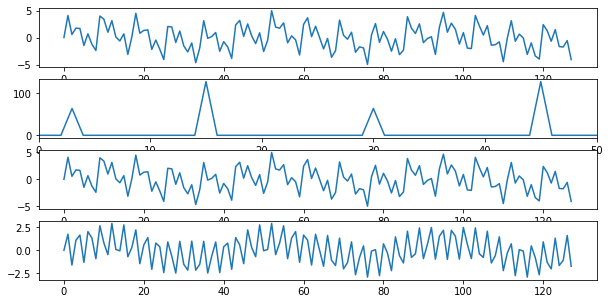

In [ ]:
from scipy.fftpack import fftfreq

# signal
x = signal()

# we have to figure out the frequency here, the signal is generated with 128 points within 1 second, so d=1/128
W = fftfreq(x.size, d=1/128)  

# Do a Fourier transform on the signal and find the amplitude in the frequency domain
freqs = FFT(x)

# Do an inverse Fourier transform on the signal
ifreqs = IFFT(freqs)
ifreqs_copy = ifreqs.copy()

# remove the two middle frequencies and only keep the low and high frequencies
freqs_low_high = freqs.copy()
freqs_low_high[np.logical_and(abs(W)<40, abs(W)>10)] = 0

# Do an inverse Fourier transform on the signal
ifreqs_low_high = IFFT(freqs_low_high)

####
plt.figure(figsize = (10, 5))
plt.subplot(411)
plt.plot(x)
plt.subplot(412)
plt.xlim(0, 50)
plt.plot(abs(freqs))
plt.subplot(413)
plt.plot(ifreqs_copy)
plt.subplot(414)
plt.plot(ifreqs_low_high)
plt.show()

### Use FFT and IFFT to multiply two polynomial functions

In [ ]:
def pad_radix2(xs, n):  # just to make sure the input is a power of 2, if not, pad it with 0s
    b = n.bit_length() - 1
    if n & (n-1): # not a power of 2
        b += 1
        n = 2 ** b
    return xs + [0] * (n - len(xs))

def poly_mult(p1, p2):
    max_n = max(len(p1), len(p2)) * 2
    y1, y2 = FFT(pad_radix2(p1, max_n)), FFT(pad_radix2(p2, max_n))
    y3 = y1*y2
    return IFFT(y3)

# calculate (1+2x)(3+4x)=3+10*x+8*x**2
print(poly_mult([1, 2], [3, 4]))

# calculate (1+2x+3x**2)(3+4x+5x**2)=3+10x+22x^2+22x^3+15x^4
print(poly_mult([1, 2, 3], [3, 4, 5]))

[(3+8.881784197001252e-16j), (10-3.599721149882556e-16j), (8-8.881784197001252e-16j), 3.599721149882556e-16j]
[(2.9999999999999982+1.7763568394002505e-15j), (10-4.0574162479713423e-16j), (22-1.5543122344752192e-15j), (22-4.82436794902991e-16j), (15.000000000000002+0j), (8.881784197001252e-16+1.3706152146031162e-15j), -2.220446049250313e-16j, -4.82436794902991e-16j]


### Use FFT and IFFT to multiply two large numbers

Use the polynomial function multiplication code above and set $x=10$:
$321 \times 543=3+10 \times 10+22 \times 10^2+22 \times 10^3 + 15 \times 10^4=174303$

### Image processing with FFT/IFFT

Multiplying the DFT of an image by a two-dimensional Gaussian function is a common way to blur an image by decreasing the magnitude of its high-frequency components.

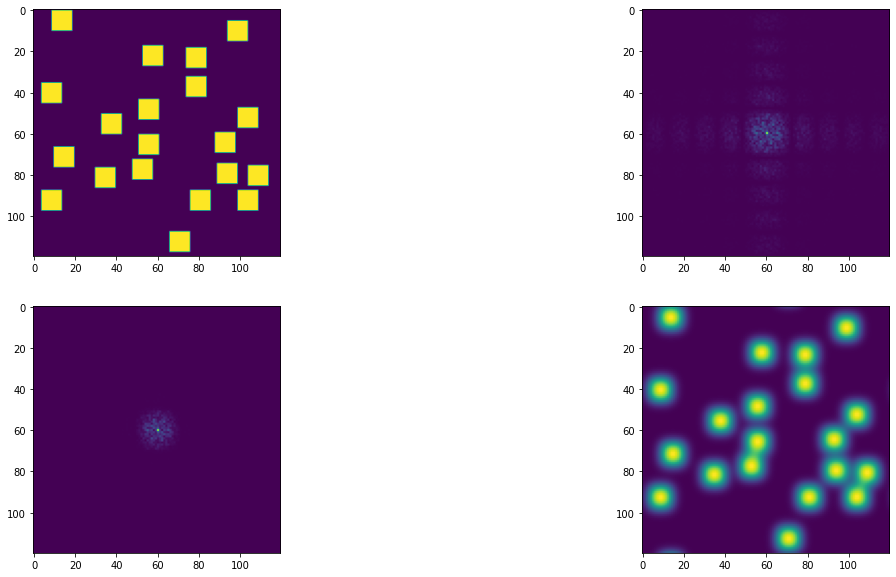

In [ ]:
# https://scipython.com/book/chapter-6-numpy/examples/blurring-an-image-with-a-two-dimensional-fft/

import numpy as np
import matplotlib.pyplot as plt

# image size, square side length, number of squares
ncols, nrows = 120, 120
sq_size, nsq = 10, 20

# The image array (0=background, 1=square) and boolean array of allowed places
# to add a square so that it doesn't touch another or the image sides
image = np.zeros((nrows, ncols))
sq_locs = np.zeros((nrows, ncols), dtype=bool)
sq_locs[1:-sq_size-1:,1:-sq_size-1] = True

# place a few squares to create an image
def place_square():
    """ Place a square at random on the image and update sq_locs. """
    # valid_locs is an array of the indices of True entries in sq_locs
    valid_locs = np.transpose(np.nonzero(sq_locs))
    # pick one such entry at random, and add the square so its top left
    # corner is there; then update sq_locs
    i, j = valid_locs[np.random.randint(len(valid_locs))]
    image[i:i+sq_size, j:j+sq_size] = 1
    imin, jmin = max(0,i-sq_size-1), max(0, j-sq_size-1)
    sq_locs[imin:i+sq_size+1, jmin:j+sq_size+1] = False

# Add the required number of squares to the image
for i in range(nsq):
    place_square()

# Take the 2-dimensional DFT and centre the frequencies
ftimage = np.fft.fft2(image)
ftimage = np.fft.fftshift(ftimage)

# Build and apply a Gaussian filter.
sigmax, sigmay = 10, 10
cy, cx = nrows/2, ncols/2
x = np.linspace(0, nrows, nrows)
y = np.linspace(0, ncols, ncols)
X, Y = np.meshgrid(x, y)
gmask = np.exp(-(((X-cx)/sigmax)**2 + ((Y-cy)/sigmay)**2))

ftimagep = ftimage * gmask

# Finally, take the inverse transform and show the blurred image
imagep = np.fft.ifft2(ftimagep)

plt.figure(figsize = (20, 10))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(np.abs(ftimage))
plt.subplot(223)
plt.imshow(np.abs(ftimagep))
plt.subplot(224)
plt.imshow(np.abs(imagep))
plt.show()

### JPEG image compression

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


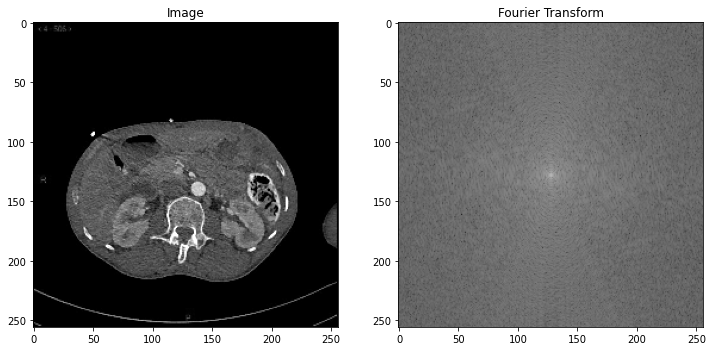

In [ ]:
import matplotlib.pyplot as plt  
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import numpy as np               
from imageio import imread   
from google.colab import drive
from google.colab import files

#mount your google drive to google colab
drive.mount('/content/drive/')

#since the code will be run on a virtual machine, we need to copy the python file to that machine in order to run it
!cp /content/drive/My\ Drive/Colab\ Notebooks/PHYS411/ExtraMaterial/aortes.jpg .

# display one image
def display(im): 
    plt.figure(figsize=(8,8))               
    plt.imshow( im, cmap="gray", vmin=0, vmax=1)  

# display two images
def display_2(im_1, title_1, im_2, title_2):
    plt.figure(figsize=(12,6))                    # Rectangular blackboard
    plt.subplot(1,2,1) ; plt.title(title_1)       # 1x2 waffle plot, 1st cell
    plt.imshow(im_1, cmap="gray")                 # Auto-equalization
    plt.subplot(1,2,2) ; plt.title(title_2)       # 1x2 waffle plot, 2nd cell
    plt.imshow(im_2, cmap="gray", vmin=-7, vmax=15)       

I = imread("./aortes.jpg", as_gray=True)  # Import as a grayscale array
I = I / 255                   # Normalize intensities in the [0,1] range
I = I[::2,::2]                # Subsample the image, for convenience
fI = fft2(I)  # Compute the Fourier transform of our slice
display_2(I, "Image", fftshift( np.log(1e-7 + abs(fI)) ), "Fourier Transform" )

Display the logarithm of the amplitutde of Fourier coefficients. The "fftshift" routine allows us to put the zero frequency in the middle of the spectrum, thus centering the right plot as expected. In other words, Fourier coefficients that are close to the center encode the low frequencies of the signal.

In [ ]:
# Truncates a Fourier Transform fI, before reconstructing a bandpassed image
def Fourier_bandpass(fI, fmin, fmax) :
    Y, X = np.mgrid[:fI.shape[0], :fI.shape[1]]  # Horizontal and vertical gradients
    radius = (X - fI.shape[0]/2) ** 2 \
           + (Y - fI.shape[1]/2) ** 2        # Squared distance to the middle point
    radius = ifftshift( np.sqrt(radius) )    # Reshape to be fft-compatible
    
    fI_band = fI.copy()               
    fI_band[ radius <=fmin ] = 0      # Remove all the low frequencies
    fI_band[ radius > fmax ] = 0      # Remove all the high frequencies
    I_band = np.real(ifft2(fI_band)) 

    display_2(I_band, "Image", fftshift( np.log(1e-7 + abs(fI_band)) ), "Fourier Transform" )

Remove more low frequencies signals from the plot to reduce the size of the image.

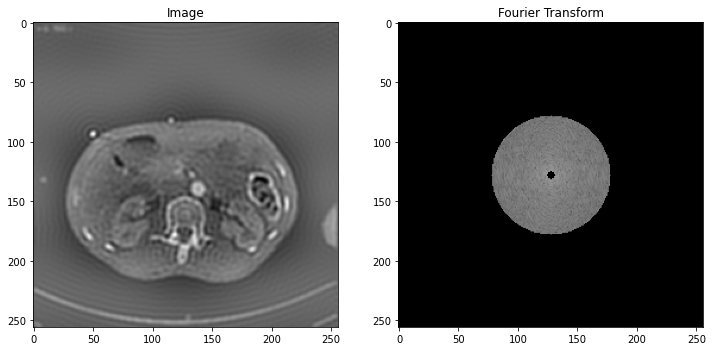

In [ ]:
Fourier_bandpass(fI, 3, 50)